### Imports

In [1]:
import os
import cv2
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from typing import List
from collections import namedtuple
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

### Labels

In [2]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# function to get the label from the name
def find_label(name):
    for label in labels:
        if label.name == name:
            return label.trainId, label.color
    return 255, (0,0,0)

### Loading Data

In [3]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
train_images_folder = '/kaggle/input/cityscapes-segmentation/images/train'
train_labels_folder = '/kaggle/input/cityscapes-segmentation/labels/train'

training_csv_file_path = '/kaggle/working/cityscapes_training.csv'
val_csv_file_path = '/kaggle/working/cityscapes_val.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# current_dir = os.path.dirname(os.getcwd())
# train_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Train_Set')
# train_labels_folder = os.path.join(current_dir, 'DataSet\\Labels\\train')

# training_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_training.csv')
# val_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_val.csv')
#--------------------------------------------------------------------------------

data = {
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}

for city in os.listdir(train_images_folder):
    city_image_folder = os.path.join(train_images_folder, city)
    city_label_folder = os.path.join(train_labels_folder, city)
    # print(f"Processing {city} ...")
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            # print(f"Processing {image_file} ...")
            if image_file.endswith('_leftImg8bit.png'):
                image_name_base = image_file.replace('_leftImg8bit.png', '')
                label_mask_file = f"{image_name_base}_gtFine_labelTrainIds.png"
                label_json_file = f"{image_name_base}_gtFine_polygons.json"
                
                data['image_path'].append(os.path.join(city_image_folder, image_file))
                data['label_mask_path'].append(os.path.join(city_label_folder, label_mask_file))
                data['label_json_path'].append(os.path.join(city_label_folder, label_json_file))

df = pd.DataFrame(data)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=23, shuffle=True)

train_df.to_csv(training_csv_file_path, index=False)
val_df.to_csv(val_csv_file_path, index=False)

In [4]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
test_images_folder = '/kaggle/input/cityscapes-segmentation/images/test'

test_csv_file_path = '/kaggle/working/cityscapes_test.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# test_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Test_Set')

# test_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_test.csv')
#--------------------------------------------------------------------------------

test_data = {
    'image_path': []
}

for city in os.listdir(test_images_folder):
    city_image_folder = os.path.join(test_images_folder, city)
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            if image_file.endswith('_leftImg8bit.png'):
                test_data['image_path'].append(os.path.join(city_image_folder, image_file))

test_df = pd.DataFrame(test_data)

test_df.to_csv(test_csv_file_path, index=False)

### EDA

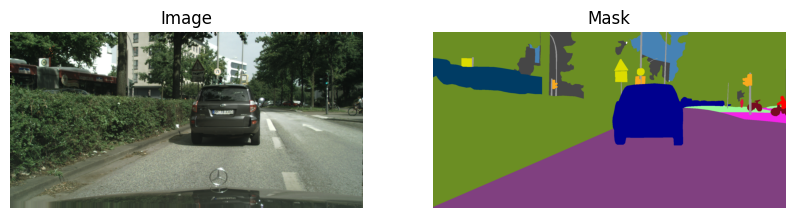

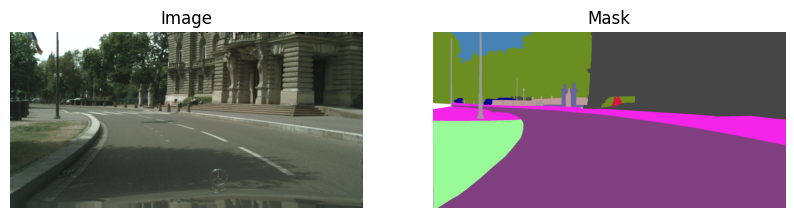

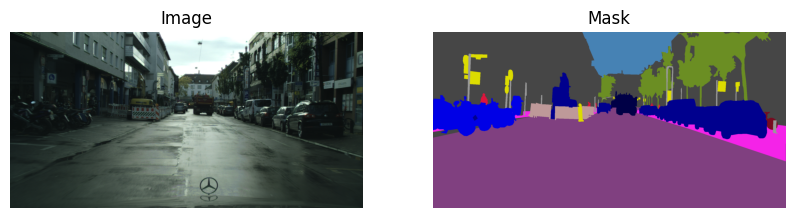

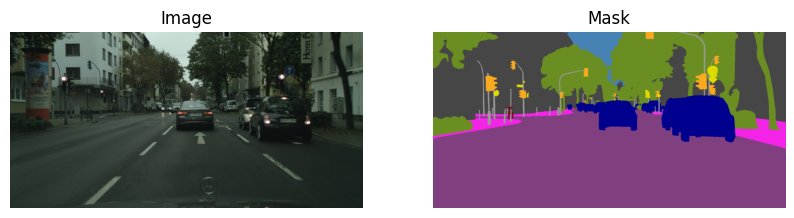

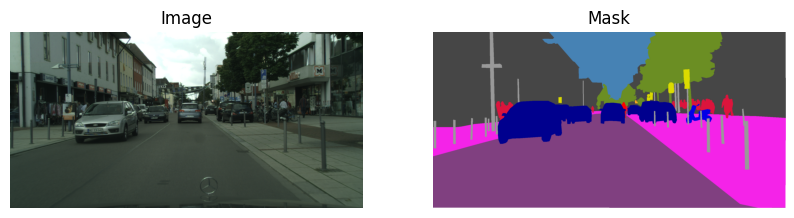

In [5]:
# Displaying A Sample of Images and Masks
def show_img_mask(row):
    image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row['label_mask_path'])

    json_data = json.load(open(row['label_json_path']))

    for obj in json_data['objects']:
        label = obj['label']
        trainId, color = find_label(label)
        if trainId != 255:
            mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask')
    plt.show()

rSample = train_df.sample(5)
for index, row in rSample.iterrows():
    show_img_mask(row)

In [6]:
# # Analyzing the Distribution of the Labels accross the train Dataset
# labels_freq = {label.name: 0 for label in labels}
# labels_not_found = {}

# dimensions_freq = {}

# for index, row in train_df.iterrows():
#     json_data = json.load(open(row['label_json_path']))
    
#     dimensions = f"{json_data['imgWidth']}x{json_data['imgHeight']}"
#     dimensions_freq[dimensions] = dimensions_freq.get(dimensions, 0) + 1

#     for obj in json_data['objects']:
#         label = obj['label']
#         if label in labels_freq:
#             labels_freq[label] += 1
#         else:
#             if label not in labels_not_found:
#                 labels_not_found[label] = 1
#             else:
#                 labels_not_found[label] += 1
        
# plt.figure(figsize=(20, 10))
# plt.bar(labels_freq.keys(), labels_freq.values())
# plt.xticks(rotation=90)
# plt.show()
# print(labels_not_found)

In [7]:
# Pixels Covered by Each Label
# def get_labels_pixels(row):
#     mask = cv2.imread(row['label_mask_path'])
#     json_data = json.load(open(row['label_json_path']))

#     for obj in json_data['objects']:
#         label = obj['label']
#         trainId, color = find_label(label)
#         if trainId != 255:
#             mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

#     return mask

# train_df['label_mask'] = train_df.apply(get_labels_pixels, axis=1)

# labels_pixels = {label.name: 0 for label in labels if label.trainId != 255}
# labels_pixels['Others'] = 0

# for index, row in train_df.iterrows():
#     for label in labels:
#         if label.trainId != 255:
#             labels_pixels[label.name] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                                 (row['label_mask'][:,:,1] == label.color[1]) &
#                                                 (row['label_mask'][:,:,2] == label.color[2]))
#         else:
#             labels_pixels['Others'] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                               (row['label_mask'][:,:,1] == label.color[1]) &
#                                               (row['label_mask'][:,:,2] == label.color[2]))

# plt.figure(figsize=(20, 10))
# plt.bar(labels_pixels.keys(), labels_pixels.values())
# plt.xticks(rotation=90)
# plt.show()

In [8]:
# Bar Plot for the Dimensions of the Images
# plt.figure(figsize=(10, 10))
# plt.bar(dimensions_freq.keys(), dimensions_freq.values())
# plt.xticks(rotation=90)
# plt.show()

# All Images have the same dimensions

### PreProcessing & Augmentation

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
import os
import json

augmented_data={
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}

target_labels = {'bus', 'rider', 'truck', 'terrain', 'wall', 'building', 'road', 'motorcycle', 'bicycle','fence','license plate'}

image_paths_with_labels = []
i=0

for index, row in train_df.iterrows():
            json_data = json.load(open(row['label_json_path']))
            
#             has_target_label = any(obj['label'] in target_labels for obj in json_data['objects'])
            target_label_count = sum(1 for obj in json_data['objects'] if obj['label'] in target_labels)
            if target_label_count>12:
                augmented_data['image_path'].append(row['image_path'])
                augmented_data['label_mask_path'].append(row['label_mask_path'])
                augmented_data['label_json_path'].append(row['label_json_path'])
                

df_augmented=pd.DataFrame(augmented_data)
print(f'Found {len(df_augmented)} images containing the specified labels:')


Found 568 images containing the specified labels:


In [11]:
#TODO : TRAIN DATA PREPROCESSING PIPELINE
csv_keys = ['image_path', 'label_mask_path', 'label_json_path']

Train_data_transform=Compose([
    ToTensor(),
    T.RandomHorizontalFlip(p=0.6),
#     T.ColorJitter(brightness=0.5),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Valid_data_transform=Compose([
    ToTensor(),
])

label_transform=Compose([
    ToTensor(),
    T.RandomHorizontalFlip(p=0.6),
])


Test_data_transform=Compose([
    ToTensor(),
])

In [12]:
class Dataset(Dataset):
    def __init__(self, input_dataframe: pd.DataFrame, KeysOfInterest: List[str], data_transform:Compose,label_transform:Compose, mask=True): # TODO: add parameters if needed
        self.koi = KeysOfInterest
        self.input_dataframe = input_dataframe[self.koi]
        self.data_transform=data_transform
        self.mask_state = mask
        self.label_transform = label_transform

    def __getitem__(self, item: int):
        # Get the path of image and the mask from the csv file
        img_path = self.input_dataframe.iloc[item]['image_path']
        mask = None
        # Read the image
        image = Image.open(img_path).convert("RGB") 
        image = image.resize((256,256))
        
        transformed_image = self.data_transform(image)
        # Read the mask
        if self.mask_state:
            mask_path = self.input_dataframe.iloc[item]['label_mask_path']

            mask = Image.open(mask_path).convert("L")
            mask = mask.resize((256,256))
            mask = self.label_transform(mask)
        
        return transformed_image, mask
        
    def __len__(self):
        return len(self.input_dataframe)

In [13]:
#TODO : Initilize your datasets
ds_train=Dataset(input_dataframe=train_df,
                KeysOfInterest=csv_keys,
                data_transform=Train_data_transform, 
                label_transform = label_transform)

ds_val=Dataset(input_dataframe=val_df,
                KeysOfInterest=csv_keys,
                data_transform=Valid_data_transform, 
                label_transform = label_transform)

ds_test=Dataset(input_dataframe=test_df,
                KeysOfInterest=["image_path"],
                data_transform=Test_data_transform, 
                label_transform = label_transform)

In [14]:
BATCH_SIZE = 2
workers = 0 #4 if Linux else 0

dl_train = DataLoader(dataset=ds_train, batch_size= BATCH_SIZE, shuffle=True, num_workers=workers)
dl_val = DataLoader(dataset=ds_val, batch_size= BATCH_SIZE, num_workers=workers, shuffle=True)
dl_test = DataLoader(dataset=ds_test, batch_size= 1, num_workers=workers, shuffle=False)

In [15]:
# # Function to show a single sample (image and mask)
# def show_sample(image_tensor, mask_tensor=None):
#     if image_tensor.is_cuda:
#         image_tensor = image_tensor.cpu()
#     if mask_tensor is not None and mask_tensor.is_cuda:
#         mask_tensor = mask_tensor.cpu()

#     # Convert the image tensor back to HWC format for plotting (CHW -> HWC)
#     image = image_tensor.permute(1, 2, 0).numpy()  # From CHW to HWC
#     image = (image).astype("uint8")  # Scale back to [0, 255] for visualization

#     # Plot the image
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.title("Image")
#     plt.axis('off')

#     # Plot the mask (if available)
#     if mask_tensor is not None:
#         plt.subplot(1, 2, 2)
#         plt.imshow(mask_tensor.numpy(), cmap='gray')
#         plt.title("Mask")
#         plt.axis('off')

#     plt.show()

# # Function to show multiple samples from a batch
# def show_data_samples(dataloader, num_batch=5):
#     for i, (image_batch, mask_batch) in enumerate(dataloader):
#         if i >= num_batch:
#             break

#         batch_size = image_batch.size(0)
#         for j in range(batch_size):
#             print(f"Sample {i*batch_size + j + 1}:")
#             show_sample(image_batch[j], mask_batch[j] if mask_batch is not None else None)

# # Example usage to show samples from the training dataloader
# show_data_samples(dl_train, num_batch=1)

In [16]:
# for i, (inputs, labels) in enumerate(dl_train):
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(torch.cuda.memory_allocated())
#     print(i)

In [18]:
import torch
import torch.nn as nn
class Convblock(nn.Module):
    
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):
            
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
    

      def forward(self,x):
        x = self.convblock(x)
        return x

In [19]:
class UNet(nn.Module):
    
    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,19,1,1)
        self.retain = retain
        
    def forward(self,x):
        
        # Encoder Network
        
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)
        
        # Decoder Network
        
        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out
    
    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [21]:
#TODO : Write the loss function you are going to use
model = UNet(3).float().to(device)

# # Check if multiple GPUs are available
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # Wrap the model with DataParallel to use multiple GPUs
#     model_dual = nn.DataParallel(device) 

In [22]:
#TODO : Write the evaluation metrics you are going to use
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [23]:
def show(img, output, label, denorm=None):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(min(len(img), 1)):  # Show only the first image for simplicity
        Img = img[i].detach().cpu().numpy().transpose(1, 2, 0)  # From (C, H, W) to (H, W, C)
        Lab = torch.argmax(output[i], dim=0).detach().cpu().numpy()  # Predicted mask as 2D array
        
        # Set pixels predicted as 'ignore' class to a neutral color (e.g., black)
        Lab[Lab == 255] = 0  # Optionally visualize ignore class as black or transparent
        
        act = label[i].detach().cpu().numpy()
        
        # Visualize the actual mask with ignore class displayed in black
        act[act == 255] = 0  # Optionally visualize ignore class in black

        ax[0].imshow(Img)  # Display the input image
        ax[1].imshow(Lab, cmap='gray')  # Display the predicted mask in grayscale
        ax[2].imshow(act, cmap='gray')  # Display the actual mask in grayscale

    plt.show()

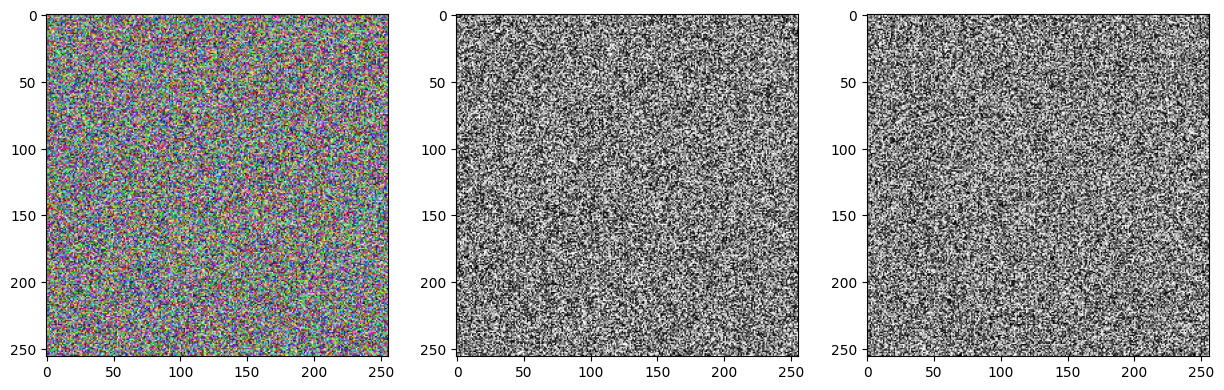

In [24]:
def test_show_before_training():
    # Creating dummy data
    batch_size = 2
    img_height, img_width = 256, 256
    
    # Random RGB image tensor [batch_size, 3, height, width]
    img = torch.rand(batch_size, 3, img_height, img_width)
    
    # Random prediction tensor [batch_size, num_classes, height, width] (19 classes)
    output = torch.rand(batch_size, 19, img_height, img_width)
    
    # Random label tensor (ground truth), with integers between 0 and 18, and 255 for ignore class
    label = torch.randint(0, 20, (batch_size, img_height, img_width)).long()  # Including 255 for ignore
    
    # Call the show function to visualize the random data
    show(img, output, label)

# Test the show function with dummy data
test_show_before_training()

In [25]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer, patience=25):
    best_val_loss = float('inf')
    early_stopping_counter = 0  

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            labels = labels.squeeze(1).long()
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
        
        if(epoch%5 == 0):
            show(inputs,outputs,labels)
            
        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                labels = labels.squeeze(1).long()
                val_loss += criterion(outputs, labels).item()

        train_loss = running_loss / len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'UNET.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    print('Finished Training')
    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(model, dl_train, dl_val, num_epochs=100,device=device, criterion=criterion, optimizer=optimizer, patience=15)

In [ ]:
#TODO : Plot losses and metrics graphs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
#TODO : Test your model and show some samples